In [1]:
import scipy
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import scipy
import math
import matplotlib.patches as patches
import pylab
import shapely.geometry as geometry
import pylab as plt
from matplotlib.path import Path
import scipy.stats

In [2]:
import geopandas as gpd
from matplotlib.path import Path


In [3]:
from shapely.geometry import Polygon, Point, MultiPolygon
import shapefile
from matplotlib.path import Path

Loading in "Truth" model run

In [5]:
era5 = xr.open_dataset('truth_SD_2018.nc')

Creating mask for the Indus basin

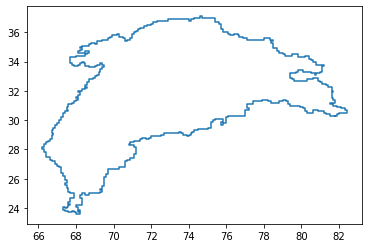

In [7]:
polygon = shapefile.Reader("../files_for_pbs/basins_hma/basins_hma.shp")
polygon = polygon.shapes()
indus = polygon[4]
listx = []
listy = []
for xNew,yNew in indus.points:
    listx.append(xNew)
    listy.append(yNew)
plt.plot(listx,listy)
plt.show()
listx = np.array(listx).reshape([837, 1])
listy = np.array(listy).reshape([837, 1])
coords = np.hstack([listx, listy])
pp = coords.tolist()
poly_path = Path(pp)

In [8]:
listx = np.array(listx).reshape([837, 1])
listy = np.array(listy).reshape([837, 1])
coords = np.hstack([listx, listy])
pp = coords.tolist()
poly_path = Path(pp)

In [9]:
lon = era5.east_west
lat = era5.north_south

In [10]:
lon = era5.east_west
lat = era5.north_south
x, y = np.meshgrid(lon, lat)
coors_grid = np.hstack((x.reshape(-1, 1), y.reshape(-1, 1)))
era5_mask = poly_path.contains_points(coors_grid)
era5_mask = era5_mask.reshape(len(lat), len(lon))

Reading in the sentinel data. Wet snow mask is not applied.

In [11]:
sentinel = xr.open_mfdataset('../Sentinel_data/HMA_sentinel_largeres3/*.nc', combine =  'nested', concat_dim = 'time')

In [10]:
sentinel.to_netcdf('INDUS_S1_obs.nc')

In [16]:
sent_time = sentinel.time.values
#delta = np.timedelta64(365, "D")
#sent_time2017 = sent_time -delta

In [14]:
sentinel = sentinel.load()

In [18]:
era5 = era5.where(era5_mask)

In [19]:
era5 = era5.SnowDepth_tavg

Selecting days from the "truth" run that actually have S1 data

In [21]:
era5_obs_SD = era5.sel(time= sent_time)
#era5_obs_SD = era5_obs.SnowDepth_inst
era5_obs_SD = era5_obs_SD.load()

In [23]:
era5_obs_SD = era5_obs_SD.where(era5_obs_SD.max('time') > 0)

Generating synthetic ovservations

Iterates through each lat/lon point. For each point, selects the vector of data over time, and adds uncertainty.

The uncertainty scales with snow depth

In [14]:
#On August 31 I increased noise from 15% to 25% in response to revisions. 

In [18]:
for n in np.arange(len(era5_obs_SD.north_south)):
    for e in np.arange(len(era5_obs_SD.east_west)):
        north_south = era5_obs_SD.north_south[n]
        east_west = era5_obs_SD.east_west[e]
        sent_vect = sentinel.snd_upd.sel({'lon': east_west, 'lat': north_south}, method = 'nearest').values
        era5 = era5_obs_SD.sel({'north_south': north_south, 'east_west': east_west}).values
        sent_nans = sent_vect * 0 #creates mask of 0s and nans
        #Adding noise to the observations
        sd_vect = (sent_nans + era5 + 0.01) * 0.25 #Adding the nan mask here makes all S1 nans transfer to truth
        rep_vect = era5 + np.random.normal(-0.01, sd_vect) #SD of nan -> nan
        era5_obs_SD[:, n, e] = rep_vect

In [19]:
# Setting any below zero observations to zero 
era5_obs_SDnozeros = era5_obs_SD.where((era5_obs_SD >= 0) | (np.isnan(era5_obs_SD)) ,0 )

In [20]:
era5_obs_SDnozeros.to_netcdf('synth_obs_Mar3.nc')

In [27]:
# Masking out wet snow observations 
obs_snow = xr.open_dataset('synth_obs_Mar3.nc')
truth = xr.open_dataset('truth_SD_2018.nc')
truth_snow = truth.SnowDepth_tavg
truth_snow_fill = truth_snow.where(truth_snow.max('time') !=0, -1)
truth_snow_fill = truth_snow_fill.where(~np.isnan(truth_snow), -1)
dates_ind = truth_snow_fill.argmax('time')
dates = truth_snow.time[dates_ind]
truth_snow_past = truth_snow_fill.where(truth_snow_fill.time >= dates)
date_none = truth_snow_past.argmin('time')
dates_2 = truth_snow.time[date_none]
truth_snow_mask = truth_snow_past.where(truth_snow_past.time < dates_2)
dry_mask = np.isnan(truth_snow_mask)
obs_snow = obs_snow.where(dry_mask)

In [29]:
obs_snow.to_netcdf('synth_obs_Mar3wetsnow.nc')

In [4]:
obs_snow = xr.open_dataset('synth_obs_Mar3wetsnow.nc')